#Libraries

In [ ]:
## Set directory to Google doc
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## File management
!pip install mat73
import mat73
import os
from scipy.io import savemat, loadmat

## Data processing
from scipy.fftpack import fft, fftshift
import matplotlib.pyplot as plt 
import numpy as np
import scipy
import random as rn
from skimage.util import random_noise

## Data visualization and plotting
import cmath as cm
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

## neural networks
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam, SGD
from torch.utils.data import TensorDataset, DataLoader, random_split
import torchvision
import torchvision.transforms as transforms

## evaluation
from skimage.metrics import structural_similarity as compare_ssim
from torch.nn import MSELoss, L1Loss, SmoothL1Loss

## dataset preparation functions
from sklearn.model_selection import train_test_split

## Warning ignore
import warnings

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
## Set randrom seed to get same results
torch.manual_seed(4460)
np.random.seed(4460)

#Data Preparation

##Data Loading

In [ ]:
## file loading
truth_file = mat73.loadmat('/content/drive/MyDrive/DeepLearning/Data/MEGA_PRESS_Data/05052023/TrainingDataClean_02stdv.mat')
input_file = mat73.loadmat('/content/drive/MyDrive/DeepLearning/Data/MEGA_PRESS_Data/05052023/TrainingDataNoise_02stdv.mat')

In [ ]:
## GROUND TRUTH data loading
truth_fid = truth_file.get('allSynthClean').T
input_fid = input_file.get('allSynthNoise').T

##Data Conversion for Troch model

In [ ]:
#from numpy.lib.type_check import real
## splitting data into train, test, and valid sets
input_train, noisy_test, truth_train, truth_test = train_test_split(input_fid, truth_fid, test_size=0.1, random_state=42)
noisy_train, noisy_valid, truth_train, truth_valid = train_test_split(input_train, truth_train, test_size=1/9, random_state=12)

############################### Inputs ############################### 
## -- split to imaginary and real due to complex does not work with regular backpropagation
## Real
noisy_train_real = torch.from_numpy(noisy_train.real).type(torch.FloatTensor).view(-1, 1, 2048)
noisy_valid_real = torch.from_numpy(noisy_valid.real).type(torch.FloatTensor).view(-1, 1, 2048)
noisy_test_real  = torch.from_numpy(noisy_test.real).type(torch.FloatTensor).view(-1, 1, 2048)
## Imaginary
noisy_train_imag = torch.from_numpy(noisy_train.imag).type(torch.FloatTensor).view(-1, 1, 2048)
noisy_valid_imag = torch.from_numpy(noisy_valid.imag).type(torch.FloatTensor).view(-1, 1, 2048)
noisy_test_imag  = torch.from_numpy(noisy_test.imag).type(torch.FloatTensor).view(-1, 1, 2048)
## --> for 2 input channels 
noisy_train_real_img = torch.cat((noisy_train_real, noisy_train_imag), axis=1)
noisy_valid_real_img = torch.cat((noisy_valid_real, noisy_valid_imag), axis=1)
noisy_test_real_img = torch.cat((noisy_test_real, noisy_test_imag), axis=1)

############################### Ground Truth ############################### 
## Complex -- compare predictions with complex is fine
truth_train = torch.from_numpy(truth_train).type(torch.complex64).view(-1, 1, 2048)
truth_valid = torch.from_numpy(truth_valid).type(torch.complex64).view(-1, 1, 2048)
truth_test  = torch.from_numpy(truth_test).type(torch.complex64).view(-1, 1, 2048)

In [ ]:
############################### Tensor Dataset ############################### 
## 2 input channels Complex
train_dataset = TensorDataset(noisy_train_real_img, truth_train)
valid_dataset = TensorDataset(noisy_valid_real_img, truth_valid)
test_dataset = TensorDataset(noisy_test_real_img, truth_test)

BATCH_SIZE = 4

############################### Data Loader ############################### 
## 2 input channels Complex
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, pin_memory=True)

# Evaluation Helper Functions

In [ ]:
def PSNR(original, compressed):
    original = original.squeeze()
    compressed = compressed.squeeze()
    batch_size = original.size()[0]

    psnr = 0
    for i in range(batch_size):
      mse = torch.abs(torch.mean((original[i] - compressed[i]) ** 2))
      if(mse == 0):  # MSE is zero means no noise is present in the signal .
          return 100 # Therefore PSNR have no importance.
    
      psnr += 20 * torch.log10(torch.max(torch.abs(original[i])) / torch.sqrt(mse))
    
    return psnr.cpu().detach().item()/ batch_size # db

def MSE(original, compressed):
    original = original.squeeze()
    compressed = compressed.squeeze()
    batch_size = original.size()[0]

    MSE = 0
    for i in range(batch_size):
      mse = torch.abs(torch.mean((original[i] - compressed[i]) ** 2))
      if(mse == 0):  # MSE is zero means no noise is present in the signal .
          return 100 # Therefore PSNR have no importance.
    
      MSE += mse.cpu().detach().item()
    
    return MSE/ batch_size

def computeGFC(original, compressed):
    """
      Source Code:
      @inproceedings{agarla2021spectralmeasures,
      author = {Agarla, Mirko and Bianco, Simone and Celona, Luigi and Schettini, Raimondo and Tchobanou, Mikhail},
      year = {2021},
      title = {An analysis of spectral similarity measures},
      organization = {Society for Imaging Science and Technology},
      booktitle = {Color and Imaging Conference},
      volume = {2021},
      number = {6},
      doi = {https://doi.org/10.2352/issn.2169-2629.2021.29.300},
      pages = {300--305},
      }
    """
    assert original.shape == compressed.shape

    original =  torch.abs(original.squeeze())
    compressed =  torch.abs(compressed.squeeze())
    batch_size = original.size()[0]

    res = 0
    for i in range(batch_size):
      o = torch.clip(original[i], 0, 1)
      c = torch.clip(compressed[i], 0, 1)

      GFCn = torch.sum(torch.multiply(o, c))

      GFCd = torch.multiply(torch.sqrt(torch.sum(torch.pow(o, 2))),
                        torch.sqrt(torch.sum(torch.pow(c, 2))))

      GFC = torch.divide(GFCn, GFCd)
      res += torch.mean(GFC).cpu().detach().item()

    return res/ batch_size

# Train Helper Functions

In [ ]:
#Github source: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, name, path, patience=3, verbose=False, delta=0, trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path+ '/' + name + '_checkpoint.pt'
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None: # initial
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score <= self.best_score + self.delta: # not improving
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        ## Saves model when validation loss decrease
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
def train_net(net, epochs, train_dataloader, valid_dataloader, optimizer, loss_function):    
    n_train = len(train_dataloader)
    n_valid = len(valid_dataloader)    
    
    train_loss = list()
    train_psnr = list()
    train_gfc = list()
    train_pearson = list()

    valid_loss = list()
    valid_psnr = list()
    valid_gfc = list()
    valid_pearson = list()
    path_name = '/content/drive/MyDrive/DeepLearning/Models'
    early_stopping = EarlyStopping(net.name, path_name, patience=7, verbose=True)

    for epoch in range(epochs):
        ################################################################################################################################
        ########################################################### Training ###########################################################
        ################################################################################################################################
        net.train()
        train_batch_loss = list()
        train_batch_psnr = list()
        train_batch_gfc = list()
        train_batch_pearson = list()

        
        for i, batch in enumerate(train_dataloader):

            # Load a batch and pass it to the GPU
            signal = batch[0].cuda()
            ground = batch[1].cuda()

            # Produce the estimated mask using current weights
            y_pred_noise = net(signal)

            # merge two channels (real and imag) to one complex channel
            y_pred_noise = torch.transpose(y_pred_noise, 2,1).contiguous()
            y_pred_noise = torch.view_as_complex(y_pred_noise).view(-1, 1, 2048)

            noise_input = torch.transpose(signal, 2,1).contiguous()
            noise_input = torch.view_as_complex(noise_input).view(-1, 1, 2048)

            # model learns about noises
            y_pred = noise_input - y_pred_noise

            # Compute the loss for this batch and append it to the epoch loss
            loss = loss_function(y_pred, ground)
            batch_loss = loss.item()
            # Compute pSNR score for this batch and append it to the epoch
            batch_psnr = PSNR(ground, y_pred)
            # Compute the GFC score for this batch and append it to the epoch GFC
            batch_GFC = computeGFC(ground, y_pred)
            # Compute the accuracy for this batch and append to the overall list
            batch_pearson = scipy.stats.pearsonr(y_pred.view(-1).float().cpu().detach(), ground.view(-1).float().cpu().detach())
            
            train_batch_psnr.append(batch_psnr)
            train_batch_gfc.append(batch_GFC)
            train_batch_loss.append(batch_loss)
            train_batch_pearson.append(batch_pearson)
    
            # Reset gradient values
            optimizer.zero_grad()
            # Compute the backward losses
            loss.backward()
            # Update the weights
            optimizer.step()
    
        ################################################################################################################################
        ########################################################## Validation ##########################################################
        ################################################################################################################################
        
        net.eval()
        valid_batch_loss = list()
        valid_batch_psnr = list()
        valid_batch_gfc = list()
        valid_batch_pearson = list()
        
        # Gradient is not caluclated this will speed up the process and cause it to consume less memory
        with torch.no_grad():
            for i, batch in enumerate(valid_dataloader):

                # Load a batch and pass it to the GPU
                signal = batch[0].cuda()
                ground = batch[1].cuda()

                # Produce the estimated mask using current weights
                y_pred_noise = net(signal)

                # merge two channels (real and imag) to one complex channel
                y_pred_noise = torch.transpose(y_pred_noise, 2,1).contiguous()
                y_pred_noise = torch.view_as_complex(y_pred_noise).view(-1, 1, 2048)
                noise_input = torch.transpose(signal, 2,1).contiguous()
                noise_input = torch.view_as_complex(noise_input).view(-1, 1, 2048)

                # model learns about noises
                y_pred = noise_input - y_pred_noise  

                # Compute the loss for this batch and append it to the epoch loss
                loss = loss_function(y_pred, ground)
                batch_loss = loss.item()
                # Compute pSNR score for this batch and append it to the epoch
                batch_psnr = PSNR(ground, y_pred)
                # Compute the GFC score for this batch and append it to the epoch
                batch_GFC = computeGFC(ground, y_pred)
                # Add items to lists
                valid_batch_gfc.append(batch_GFC)
                valid_batch_psnr.append(batch_psnr)
                valid_batch_loss.append(batch_loss)
                
                # Compute the accuracy for this batch and append to the overall list
                batch_pearson = scipy.stats.pearsonr(y_pred.view(-1).float().cpu().detach(), ground.view(-1).float().cpu().detach())
                valid_batch_pearson.append(batch_pearson)


        # calculate average per batch sample
        average_training_loss = np.array(train_batch_loss).mean()
        average_train_psnr = np.array(train_batch_psnr).mean()
        average_train_gfc = np.array(train_batch_gfc).mean()
        average_train_pearson = np.array(train_batch_pearson).mean()
        average_validation_loss = np.array(valid_batch_loss).mean()
        average_valid_psnr =    np.array(valid_batch_psnr).mean()
        average_valid_gfc =     np.array(valid_batch_gfc).mean()
        average_valid_pearson = np.array(valid_batch_pearson).mean()
        # add items to lists
        train_loss.append(average_training_loss)
        train_psnr.append(average_train_psnr)
        train_gfc.append(average_train_gfc)
        train_pearson.append(average_train_pearson)
        valid_loss.append(average_validation_loss)
        valid_psnr.append(average_valid_psnr)
        valid_gfc.append(average_valid_gfc)
        valid_pearson.append(average_valid_pearson)

        # print progress
        print(f'EPOCH {epoch + 1}/{epochs} - Training Loss: {average_training_loss}, Training pearson score: {average_train_pearson}, Training psnr score: {average_train_psnr}, Training GFC score: {average_train_gfc} Validation Loss: {average_validation_loss}, Validation pearson score: {average_valid_pearson}, Validation psnr score: {average_valid_psnr}, Validation GFC score: {average_valid_gfc} ')
        
        # Early Stopping
        early_stopping(average_validation_loss, net)
        if early_stopping.early_stop:
            print("Early stopping at epoch %d" %epoch)
            break
    
    return train_loss, train_psnr, train_gfc, train_pearson, valid_loss, valid_psnr, valid_gfc, valid_pearson

#Model Architectures

##Dn-ResUNet

In [ ]:
KERNEL_SIZE = 3
P = (KERNEL_SIZE - 1)//2

In [ ]:
class ConvBlock(nn.Module):
    """(convolution => [BN] => ReLU)"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.convblock = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=KERNEL_SIZE, padding=P, padding_mode = 'replicate'),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
      x = self.convblock(x)
      return x

class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.BatchNorm1d(in_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(in_channels, out_channels, kernel_size=KERNEL_SIZE, padding=P, padding_mode = 'replicate'),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv1d(out_channels, out_channels, kernel_size=KERNEL_SIZE, padding=P, padding_mode = 'replicate')
        )
        self.block2 = nn.Sequential(
          ConvBlock(in_channels, out_channels)
        )

    def forward(self, x):
        return self.block1(x) + self.block2(x)

class Up(nn.Module):
  def __init__(self, in_channels, out_channels):
     super().__init__()
     self.up = nn.Sequential(
         nn.Upsample(scale_factor=2, mode='linear', align_corners=True),
         nn.Conv1d(in_channels, out_channels, kernel_size=1, padding=0)
     )
     self.conv = ResBlock(out_channels * 2, out_channels)

  def forward(self, x1, x2):
      x1 = self.up(x1)
      x = torch.cat([x1, x2], dim=1)
      return self.conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool1d(2),
            ResBlock(in_channels, out_channels)
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv_tanh = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=1),
            nn.BatchNorm1d(out_channels),
            nn.Tanh()
        )

    def forward(self, x):
        return self.conv_tanh(x)

In [ ]:
class DnResUNet(nn.Module):

    def __init__(self, name, n_channels, n_out):
        super(DnResUNet, self).__init__()
        self.name = name
        self.n_channels = n_channels
        self.n_out = n_out
        self.inputL = ConvBlock(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 512)
        self.down5 = Down(512, 1024)
        self.conv = ConvBlock(1024, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.up5 = Up(64, 32)

        self.outputL = OutConv(32, n_out)
        
    def forward(self, x):
        x1 = self.inputL(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        b = self.down5(x5)
        b = self.conv(b)
        x = self.up1(b, x5)
        x = self.up2(x, x4)
        x = self.up3(x, x3)
        x = self.up4(x, x2)
        x = self.up5(x, x1)
        
        x = self.outputL(x)
        
        return x

##LSTM

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, name, in_dim = 2048, hidden_dim = 2048, out_size = 2048):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.name = name

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(in_dim, hidden_dim, batch_first = True)

        # The linear layer that maps from hidden state space to tag space
        self.fc = nn.Linear(hidden_dim, out_size)

    def forward(self, x):
        x, (hn, cn) = self.lstm(x)
        #print(x.size())
        x = x.view(-1, 2048)
        x = self.fc(x)

        return x.view(-1, 1, 2048)

#Train


## Define model

In [ ]:
dnresunet = DnResUNet('dnresunet0.2_model', 2, 2)

if torch.cuda.is_available():
  print("GPU available:", torch.cuda)
  dnresunet.cuda()

else:
  print('SWITCH TO GPU')

pytorch_total_params = sum(p.numel() for p in dnresunet.parameters())
print('Total number of parameters: ', pytorch_total_params)

GPU available: <module 'torch.cuda' from '/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py'>


##Training the model

In [ ]:
## define loss and optimizer
dnresunet_optimizer = torch.optim.Adam(dnresunet.parameters(), lr=1e-6)
dnresunet_loss_function = L1Loss()

In [ ]:
EPOCHS = 50
dnresunet_train_loss, dnresunet_train_psnr, dnresunet_train_gfc, dnresunet_train_pearson, dnresunet_valid_loss, dnresunet_valid_psnr, dnresunet_valid_gfc, dnresunet_valid_pearson = train_net(dnresunet, EPOCHS, train_loader, valid_loader, dnresunet_optimizer, dnresunet_loss_function)
#lstm_real_train_loss, lstm_real_train_psnr, lstm_real_train_gfc, lstm_real_train_pearson, lstm_real_valid_loss, lstm_real_valid_psnr, lstm_real_valid_gfc, lstm_real_valid_pearson = train_net(lstm_real, EPOCHS, real_train_loader, real_valid_loader, lstm_real_optimizer, lstm_real_loss_function)
#lstm_imag_train_loss, lstm_imag_train_psnr, lstm_imag_train_gfc, lstm_imag_train_pearson, lstm_imag_valid_loss, lstm_imag_valid_psnr, lstm_imag_valid_gfc, lstm_imag_valid_pearson = train_net(lstm_imag, EPOCHS, imag_train_loader, imag_valid_loader, lstm_imag_optimizer, lstm_imag_loss_function)



EPOCH 1/50 - Training Loss: 0.24647733863496354, Training pearson score: 0.44020870252316624, Training psnr score: 34.378449988365176, Training GFC score: 0.6300505135463816 Validation Loss: 0.20033437626276698, Validation pearson score: 0.4521022633985892, Validation psnr score: 35.53691694205148, Validation GFC score: 0.6983404885530472 
Validation loss decreased (inf --> 0.200334).  Saving model ...
EPOCH 2/50 - Training Loss: 0.19303529728682978, Training pearson score: 0.4541088157332171, Training psnr score: 35.70221855204446, Training GFC score: 0.7109334677521671 Validation Loss: 0.18862908232212067, Validation pearson score: 0.45511512446583646, Validation psnr score: 35.82652772412981, Validation GFC score: 0.7155542017051152 
Validation loss decreased (0.200334 --> 0.188629).  Saving model ...
EPOCH 3/50 - Training Loss: 0.18568317326743689, Training pearson score: 0.45594805517638776, Training psnr score: 35.92283046477181, Training GFC score: 0.720478592010481 Validation L

In [ ]:
import shutil
# move the model file to drive
shutil.move('/content/dnresunet0.2_model_checkpoint.pt', '/content/drive/MyDrive/DeepLearning/Models/dnresunet0.2_model_checkpoint.pt')


'/content/drive/MyDrive/DeepLearning/Models/dnresunet0.2_model_checkpoint.pt'

## Plot loss

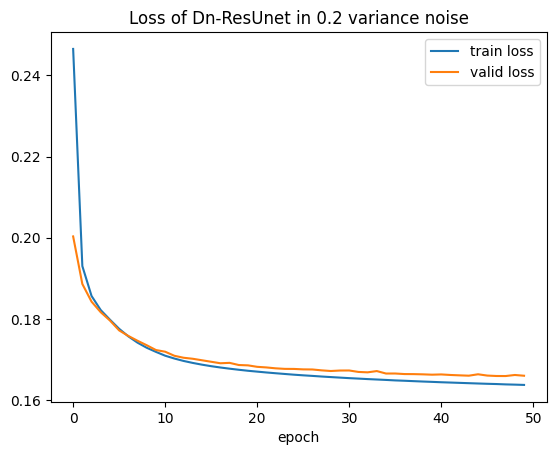

In [ ]:
plt.title('Loss of Dn-ResUnet in 0.2 variance noise')
plt.xlabel('epoch')
plt.plot(dnresunet_train_loss, label = 'train loss');
plt.plot(dnresunet_valid_loss, label = 'valid loss');
plt.legend()

#Evaluation

##Data Loading for spectrum evaluations



In [ ]:
## file loading
eval_truth_file = loadmat('/content/drive/MyDrive/DeepLearning/Data/MEGA_PRESS_Data/figure_data/clean4000.mat')
eval_input_file = loadmat('/content/drive/MyDrive/DeepLearning/Data/MEGA_PRESS_Data/figure_data/noise3999.mat')

## GROUND TRUTH data loading
eval_truth_fid = eval_truth_file.get('clean').T
eval_input_fid = eval_input_file.get('noise').T

noisy_eval_real = torch.from_numpy(eval_input_fid.real).type(torch.FloatTensor).view(-1, 1, 2048)
noisy_eval_imag  = torch.from_numpy(eval_input_fid.imag).type(torch.FloatTensor).view(-1, 1, 2048)
## This is the final two channel data we want to use
noisy_eval_real_img = torch.cat((noisy_eval_real, noisy_eval_imag), axis=1)

############################### Ground Truth ############################### 
## Complex -- compare predictions with complex is fine
truth_eval = torch.from_numpy(eval_truth_fid).type(torch.complex64).view(-1, 1, 2048)


eval_dataset = TensorDataset(noisy_eval_real_img, truth_eval)

In [ ]:
eval_loader = DataLoader(eval_dataset, batch_size=1, pin_memory=True)

## Test Helper function

In [ ]:
def test_net(net, test_dataloader, loss_function):
    
    net.eval()
    n_test = len(test_dataloader)
    test_loss = list()
    test_psnr = list()
    test_gfc = list()
    test_mse = list()


    # This part is almost the same as the validation loop in `train_net` function. 
    # The difference is that we will calculate the accuracy and confusion matrix per each batch and save the predicted images.
    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):


          # Load a batch and pass it to the GPU

          signal = batch[0].cuda()
          ground = batch[1].cuda()
          

          # Produce the estimated mask using current weights
          y_pred_noise = net(signal)
          if not 'lstm' in net.name:
            y_pred_noise = torch.transpose(y_pred_noise, 2,1).contiguous()
            y_pred_noise = torch.view_as_complex(y_pred_noise).view(-1, 1, 2048)


          noise_input = torch.transpose(signal, 2,1).contiguous()
          noise_input = torch.view_as_complex(noise_input).view(-1, 1, 2048)
          y_pred = noise_input - y_pred_noise  


          loss = loss_function(y_pred, ground)

          batch_loss = loss.item()
          test_loss.append(batch_loss)
          # Compute pSNR score for this batch and append it to the epoch
          batch_psnr = PSNR(ground, y_pred)
          test_psnr.append(batch_psnr)
          # Compute pSNR score for this batch and append it to the epoch
          batch_mse = MSE(ground, y_pred)
          test_mse.append(batch_mse)
          # Compute the GFC score for this batch and append it to the epoch GFC
          batch_GFC = computeGFC(ground, y_pred)
          test_gfc.append(batch_GFC)
            

    test_loss = np.array(test_loss).mean()
    test_psnr = np.array(test_psnr).mean()
    test_gfc = np.array(test_gfc).mean()
    test_mse = np.array(test_mse).mean()


    
    return test_loss, test_psnr, test_gfc, test_mse

In [ ]:
def get_outputs(net, test_dataloader):
    
    net.eval()
    outputs = list()
    truths = list()

    with torch.no_grad():
        for i, batch in enumerate(test_dataloader):
          # Load a batch and pass it to the GPU

          signal = batch[0].cuda()
          ground = batch[1].squeeze().numpy()
          

          # Produce the estimated mask using current weights
          y_pred_noise = net(signal)
          if not 'lstm' in net.name:
            y_pred_noise = torch.transpose(y_pred_noise, 2,1).contiguous()
            y_pred_noise = torch.view_as_complex(y_pred_noise).view(-1, 1, 2048)


          noise_input = torch.transpose(signal, 2,1).contiguous()
          noise_input = torch.view_as_complex(noise_input).view(-1, 1, 2048)
          y_pred = noise_input - y_pred_noise  

          res = y_pred.squeeze().clone().detach().cpu().numpy()

          for j in range(res.shape[0]):
            outputs.append(res[j])
            truths.append(ground[j])

    outputs = np.array(outputs)
    truths = np.array(truths)
    
    return outputs, truths

## Load model

In [ ]:
model_1 = DnResUNet('dnresunet0.1_model', 2, 2)
model_2 = DnResUNet('dnresunet0.2_model', 2, 2)
loss_function = L1Loss()

if torch.cuda.is_available():
  print("GPU available:", torch.cuda)
  model_1.cuda()
  model_2.cuda()
else:
  print('SWITCH TO GPU')           
           
model_1_file = '/content/drive/MyDrive/DeepLearning/Models/dnresunet_0.1_checkpoint.pt'
model_2_file = '/content/drive/MyDrive/DeepLearning/Models/dnresunet_0.2_checkpoint.pt'

model_1.load_state_dict(torch.load(model_1_file))
model_2.load_state_dict(torch.load(model_2_file))

GPU available: <module 'torch.cuda' from '/usr/local/lib/python3.10/dist-packages/torch/cuda/__init__.py'>


<All keys matched successfully>

##Saved outputs for LCM in MATLAB

In [ ]:
outputs, truths = get_outputs(model_2, eval_loader)
output_file = {'prediction': outputs.reshape(-1, 1), 'truths': truths.reshape(-1, 1)}
savemat('/content/drive/MyDrive/DeepLearning/Data/dnresunet_02_3999.mat', output_file)

##Print evaluations

In [ ]:
test_loss1, test_psnr1, test_gfc1, test_mse1 = test_net(model_1, test_loader, loss_function)
print('############################# 0.1 var #############################')
print(f'Test Loss: {test_loss1}\nTest PSNR: {test_psnr1}\nTest GFC: {test_gfc1}\nTest MSE: {test_mse1}')

test_loss2, test_psnr2, test_gfc2, test_mse2 = test_net(model_2, test_loader, loss_function)
print('############################# 0.2 var #############################')
print(f'Test Loss: {test_loss2}\nTest PSNR: {test_psnr2}\nTest GFC: {test_gfc2}\nTest MSE: {test_mse2}')

############################# 0.1 var #############################
Test Loss: 0.18151756605505942
Test PSNR: 43.400841064453125
Test GFC: 0.8057336648106574
Test MSE: 0.006262349189198825
############################# 0.2 var #############################
Test Loss: 0.16548187959407057
Test PSNR: 40.91892700195312
Test GFC: 0.8155482175009591
Test MSE: 0.010503353620243225
